# Kmeans Clustering

In [1]:
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pyspark

from pyspark.sql import SparkSession
from pyspark.sql.functions import *

from pyspark.ml.feature import VectorAssembler

from pyspark.ml.tuning import TrainValidationSplit, ParamGridBuilder
from pyspark.ml.tuning import TrainValidationSplitModel

from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

In [2]:
#env variables
write_files = True
fit_model = True
model_path = "file:///home/work/data/kmeans_movies_model"

In [3]:
# Change the number of cores in this code block
# by setting `spark.master` to `local[n]` where
# n is the number of cores

conf = pyspark.SparkConf().setAll([('spark.master', 'local[4]'),
                                   ('spark.app.name', 'KMEANS Clustering')])
spark = SparkSession.builder.config(conf=conf).getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
2022-05-26 22:03:47,464 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
df = spark.read.option("header",True).csv("file:///home/work/data/kmeans_movies_train.csv", inferSchema=True)
df.printSchema()

root
 |-- movieId: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- avg_rating: double (nullable = true)
 |-- movieYear: integer (nullable = true)
 |-- genres: string (nullable = true)
 |-- Crime: double (nullable = true)
 |-- Romance: double (nullable = true)
 |-- Thriller: double (nullable = true)
 |-- Adventure: double (nullable = true)
 |-- Drama: double (nullable = true)
 |-- War: double (nullable = true)
 |-- Documentary: double (nullable = true)
 |-- Fantasy: double (nullable = true)
 |-- Mystery: double (nullable = true)
 |-- Musical: double (nullable = true)
 |-- Animation: double (nullable = true)
 |-- Film-Noir: double (nullable = true)
 |-- Horror: double (nullable = true)
 |-- Western: double (nullable = true)
 |-- Comedy: double (nullable = true)
 |-- Children: double (nullable = true)
 |-- Action: double (nullable = true)
 |-- Sci-Fi: double (nullable = true)



In [5]:
df.show(5)

+-------+--------------------+------------------+---------+--------------------+-----+-------+--------+---------+-----+---+-----------+-------+-------+-------+---------+---------+------+-------+------+--------+------+------+
|movieId|               title|        avg_rating|movieYear|              genres|Crime|Romance|Thriller|Adventure|Drama|War|Documentary|Fantasy|Mystery|Musical|Animation|Film-Noir|Horror|Western|Comedy|Children|Action|Sci-Fi|
+-------+--------------------+------------------+---------+--------------------+-----+-------+--------+---------+-----+---+-----------+-------+-------+-------+---------+---------+------+-------+------+--------+------+------+
|      1|    Toy Story (1995)| 3.893707794587238|     1995|Adventure|Animati...|  0.0|    0.0|     0.0|      1.0|  0.0|0.0|        0.0|    1.0|    0.0|    0.0|      1.0|      0.0|   0.0|    0.0|   1.0|     1.0|   0.0|   0.0|
| 100008|    Flaw, The (2011)|3.5714285714285716|     2011|         Documentary|  0.0|    0.0|     0

*Checking null values in each column*

*Printing movies without year in it*

In [6]:
df.describe().toPandas()

,summary,movieId,title,avg_rating,movieYear,genres,Crime,Romance,Thriller,Adventure,...,Mystery,Musical,Animation,Film-Noir,Horror,Western,Comedy,Children,Action,Sci-Fi
0,count,19199,19199,19199,19183,19199,19199,19199,19199,19199,...,19199,19199,19199,19199,19199,19199,19199,19199,19199,19199
1,mean,70549.19542684515,None,3.199374593462552,1994.68216650159,None,0.10755768529610918,0.14922652221469868,0.1743840825042971,0.09052554820563571,...,0.057034220532319393,0.030261992812125632,0.057607167039949995,0.011250585968019167,0.10932861086514922,0.01942809521329236,0.32215219542684514,0.05578415542476171,0.14214281993853847,0.07604562737642585
2,stddev,62391.0281378223,None,0.49313590629512494,22.061178773138895,None,0.3098290328218229,0.3563208952130042,0.3794493032207878,0.2869406939252881,...,0.2319140349843596,0.17131180114210148,0.2330051698362607,0.10547317061361562,0.3120591897372535,0.13802766626333104,0.46731309958005357,0.22951040730694164,0.3492056561540999,0.26507800706526186
3,min,1,"""""""Great Performances"""" Cats (1998)""",0.6785714285714286,1888,Action,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,max,208737,Я худею (2018),4.483096085409253,2019,Western,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [7]:
col_names = df.columns
exc_cols = ['movieId', 'title', 'genres', 'movieYear']
feat_cols = sorted(list(set(col_names).difference(set(exc_cols))))
feat_cols

['Action',
 'Adventure',
 'Animation',
 'Children',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Fantasy',
 'Film-Noir',
 'Horror',
 'Musical',
 'Mystery',
 'Romance',
 'Sci-Fi',
 'Thriller',
 'War',
 'Western',
 'avg_rating']

### Creating features

### Vector assembler to create feature vector column

In [8]:
assembler = VectorAssembler(inputCols=feat_cols, outputCol='features', handleInvalid='skip')
train = assembler.transform(df)
train.show(5)

2022-05-26 22:03:55,717 WARN util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+--------------------+------------------+---------+--------------------+-----+-------+--------+---------+-----+---+-----------+-------+-------+-------+---------+---------+------+-------+------+--------+------+------+--------------------+
|movieId|               title|        avg_rating|movieYear|              genres|Crime|Romance|Thriller|Adventure|Drama|War|Documentary|Fantasy|Mystery|Musical|Animation|Film-Noir|Horror|Western|Comedy|Children|Action|Sci-Fi|            features|
+-------+--------------------+------------------+---------+--------------------+-----+-------+--------+---------+-----+---+-----------+-------+-------+-------+---------+---------+------+-------+------+--------+------+------+--------------------+
|      1|    Toy Story (1995)| 3.893707794587238|     1995|Adventure|Animati...|  0.0|    0.0|     0.0|      1.0|  0.0|0.0|        0.0|    1.0|    0.0|    0.0|      1.0|      0.0|   0.0|    0.0|   1.0|     1.0|   0.0|   0.0|(19,[1,2,3,4,8,18...|
| 100008|    Fla

#### Cluster Evaluator to check how close the points in individual clusters are ?

In [9]:
%%time
cluster_list = list(range(10,1501,10))
kmeans_algo = KMeans(featuresCol='features', seed=0, maxIter=1000, distanceMeasure="cosine")
evaluator = ClusteringEvaluator(predictionCol='prediction',
                          featuresCol='features',
                          metricName='silhouette',
                          distanceMeasure='cosine')


grid = ParamGridBuilder().addGrid(kmeans_algo.k, cluster_list).build()

tvs = TrainValidationSplit(estimator=kmeans_algo, estimatorParamMaps=grid, evaluator=evaluator, parallelism=1, seed=0)

if fit_model:
    tvsModel = tvs.fit(train)
    
if write_files:
    tvsModel.write().save(model_path)

CPU times: user 15 s, sys: 3.55 s, total: 18.6 s
Wall time: 2h 20min 14s


In [10]:
test_df = spark.read.option("header",True).csv("file:///home/work/data/kmeans_movies_test.csv", inferSchema=True)
test = assembler.transform(test_df)

In [11]:
tvsModel = TrainValidationSplitModel.read().load(model_path)

In [12]:
tvsModel.bestModel

KMeansModel: uid=KMeans_4dde5a76d462, k=1350, distanceMeasure=cosine, numFeatures=19

In [13]:
%%time
evaluator.evaluate(tvsModel.transform(train))

CPU times: user 18.8 ms, sys: 659 µs, total: 19.5 ms
Wall time: 13.5 s


0.6355963350995041

In [14]:
%%time
evaluator.evaluate(tvsModel.transform(test))

CPU times: user 7.63 ms, sys: 3.38 ms, total: 11 ms
Wall time: 2.47 s


0.5725490613357676

K: 1350 cosine score: 0.6031929712453477


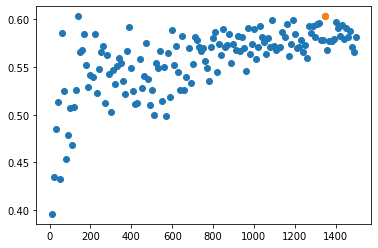

In [15]:
plt.scatter(cluster_list, tvsModel.validationMetrics)
k = tvsModel.bestModel.getK()
k_i = int((k /10) - 1)
plt.scatter(k, tvsModel.validationMetrics[k_i])
print(f'K: {k} cosine score: {tvsModel.validationMetrics[k_i]}')

## old version for clustering

#### We might not need scaling, but did it anyway for learning purpose

In [24]:
# from pyspark.ml.feature import StandardScaler
# scaler = StandardScaler(inputCol='features',
#                        outputCol='scaled_feat',
#                        withStd=True,
#                        withMean=False
#                        )
# scaled_model = scaler.fit(final_df)
# cluster_df = scaled_model.transform(final_df)

In [25]:
eval = ClusteringEvaluator(predictionCol='prediction',
                          featuresCol='features',
                          metricName='silhouette',
                          distanceMeasure='cosine')

In [26]:
### KMeans clustering 

In [27]:
silhouette_score = {}
print("""
Silhouette Scores for K Means Clustering
========================================
Model\tScore\t
=====\t=====\t
""")
start = time.time()
for k in range(10,1501,10):
    kmeans_algo = KMeans(featuresCol='features', k=k, seed=0, maxIter=1000, distanceMeasure="cosine")
    kmeans_fit = kmeans_algo.fit(final_df)
    output = kmeans_fit.transform(final_df)
    score = eval.evaluate(output)
    silhouette_score[k] = score
    if k % 100 == 0:
        # aaa = max(silhouette_score, key = silhouette_score.get) 
        # print(f"Max cluster: {aaa} Value: {silhouette_score[aaa]}")
        #print(k)
        score = silhouette_score[k]
    # silhouette_score.append(score)
        print(f"K{k}\t{score}\t")
end = time.time()
print(f"Runtime: {end - start}")


Silhouette Scores for K Means Clustering
Model	Score	
=====	=====	



K100	0.4911384049346461	


K200	0.6011487277159006	


K300	0.6037404968788649	


K400	0.5704880224742896	


K500	0.5610350492519955	


K600	0.5864398393095522	


K700	0.5973663145855811	


K800	0.6086745281340327	


2022-05-24 23:49:48,844 WARN storage.BlockManager: Asked to remove block broadcast_7164, which does not exist
2022-05-24 23:49:48,845 WARN storage.BlockManager: Asked to remove block broadcast_7164_piece0, which does not exist


K900	0.5901716824791304	


K1000	0.610391761548594	


K1100	0.619862509547975	


K1200	0.6231700509471289	


K1300	0.6225412733574711	


K1400	0.6323966128250412	


K1500	0.6348022729211157	
Runtime: 24536.007717847824


In [28]:
# silhouette_score
score_df = pd.DataFrame(silhouette_score.items(), columns=['clusters', 'score'])
score_df

,clusters,score
0,10,0.330907
1,20,0.442582
2,30,0.494541
3,40,0.485320
4,50,0.471295
...,...,...
145,1460,0.636298
146,1470,0.640617
147,1480,0.634447
148,1490,0.635793


In [29]:
score_df.loc[score_df.score.argmax(), :]

clusters    1370.00000
score          0.64189
Name: 136, dtype: float64

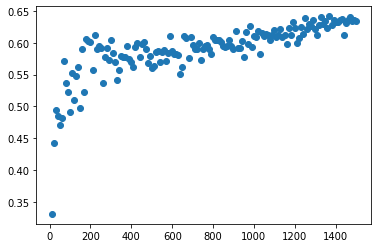

In [30]:
plt.scatter(score_df.clusters, score_df.score)

#### The above score should give us idea if points inside clusters are close to each other.

In [32]:
spark.stop()